# Regressione non Lineare

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Setup

- Importare i package necessari

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- In Jupyter, configurare l'output di matplotlib integrato nel notebook

In [2]:
%matplotlib inline

## Caso di Studio 1: Predizione Consumo Elettricità

- Carichiamo i dati già visti nel laboratorio precedente: per ogni giorno degli anni dal 2015 al 2017 abbiamo la temperatura media in una città e il picco registrato di consumo di corrente elettrica
  - con l'opzione `index_col` specifichiamo che la colonna `date` costituisce l'indice del DataFrame
  - con `parse_dates` indichiamo che i suoi valori vanno interpretati come date

In [3]:
import os.path
if not os.path.exists("power.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/vpaM1", "power.csv")

In [4]:
data = pd.read_csv("https://git.io/vpaM1", index_col="date", parse_dates=["date"])

In [5]:
data.head(3)

demand  temp
date                      
2015-01-01  1.736065   1.7
2015-01-02  1.831672   2.2
2015-01-03  1.714934  14.4

## Divisione tra Training e Validation Set

- Abbiamo visto che per verificare se un modello generalizza correttamente i dati su cui è addestrato, è importante **validarlo su dati diversi**
- Il metodo _hold-out_ prevede di dividere i dati a disposizione in un _training set_ su cui addestrare il modello e un _validation set_ su cui verificare l'accuratezza
- A supporto del metodo hold-out, scikit-learn fornisce una funzione `train_test_split` per **suddividere casualmente un set di dati** in due insiemi "train" e "test" disgiunti
  - il set di dati può essere qualsiasi struttura dati sequenziale, di solito array NumPy o serie o DataFrame pandas
  - con l'opzione `test_size=X` si indica la proporzione (se X decimale tra 0 e 1) o il numero di elementi (se X intero) da inserire nel test piuttosto che nel train (default 0.25, ovvero 25\%)
  - con l'opzione `random_state` si indica un seed per la riproducibilità
- Ad esempio, dividiamo il DataFrame `data` in due parti `train_data` e `val_data`, contenenti rispettivamente 2/3 e 1/3 dei dati

In [6]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=1/3, random_state=42)

- I due nuovi DataFrame contengono due sottoinsiemi disgiunti delle righe di `data_summer`, mescolate casualmente

In [7]:
train_data.shape

(730, 2)

In [8]:
train_data.head(3)

demand  temp
date                      
2017-12-09  1.683743   2.2
2016-09-22  2.320480  30.0
2017-10-12  1.672455  20.0

In [9]:
val_data.shape

(366, 2)

In [10]:
val_data.head(3)

demand  temp
date                      
2015-02-14  1.981781  -2.2
2016-07-22  2.526696  31.1
2015-02-26  2.086202  -6.1

- A `train_test_split` possiamo passare **due (o più) collezioni** con pari numero di elementi per far sì che siano suddivise insieme, applicando **a tutte lo stesso ordine** casuale dei dati
- Ad esempio separiamo `data` in due strutture dati allineate:
  - un DataFrame X con i valori delle variabili indipendenti (quì una sola, la temperatura)
  - una serie y con i valori della variabile dipendente (il consumo)

In [11]:
X = data[["temp"]]
y = data["demand"]

- Applichiamo quindi `train_test_split` congiuntamente a X e y

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

- Si può verificare che l'ordine delle righe di `X_train` è lo stesso di `y_train` (lo stesso vale per `X_val` e `y_val`)

In [13]:
X_train.head(3)

temp
date            
2017-12-09   2.2
2016-09-22  30.0
2017-10-12  20.0

In [14]:
y_train.head(3)

date
2017-12-09    1.683743
2016-09-22    2.320480
2017-10-12    1.672455
Name: demand, dtype: float64

In [15]:
np.array_equal(X_train.index, y_train.index)

True

## Ripasso: Modello Lineare

- Abbiamo visto come addestrare con scikit-learn un modello di regressione lineare
  - in tale modello, il valore della variabile dipendente è previsto come somma di quelli delle variabili indipendenti moltiplicati per diversi coefficienti
- Dapprima si crea un modello vuoto

In [16]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()

- Si usa quindi il metodo `fit` per addestrare il modello, passando
  - una matrice con $m\times n$ valori, ovvero $m$ osservazioni di $n$ variabili indipendenti
  - un vettore con i corrispondenti $m$ valori della variabile dipendente
- Addestriamo tale modello sui dati del training set

In [19]:
lrm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## Misurare l'Errore del Modello

- Per misurare l'errore che un modello $h(\mathbf{x})$ compie su un set di dati esistono diverse metriche
- L'_errore quadratico medio_ è utilizzato come criterio per individuare il modello migliore
$$ \mathrm{MSE} = \frac{1}{m}\sum_{i=1}^n\left(h(\mathbf{x}_i)-y_i\right)^2 $$
- Per calcolarlo possiamo usare la funzione `mean_squared_error` fornita da scikit-learn nel modulo `metrics`, che definisce diverse misure d'errore dei modelli

In [20]:
from sklearn.metrics import mean_squared_error

- Alla funzione vanno passati il vettore (o serie) dei valori reali della variabile dipendente e il vettore delle corrispondenti predizioni
- Ad esempio, l'errore del modello sopra è:

In [21]:
#                  valori reali   valori predetti
mean_squared_error(y_val,         lrm.predict(X_val))

0.09876916803996563

- Altre misure sono utilizzate per ottenere una stima più facilmente interpretabile dell'errore
- L'_errore relativo_ misura intuitivamente di quanto il modello si sbaglia in percentuale rispetto al valore reale
$$ \mathrm{errore} = \frac{1}{m}\sum_{i=1}^m\left\vert\frac{h(\mathbf{x}_i)-y_i}{y_i}\right\vert $$
- Ad esempio, se il valore reale da predire è 2 GW, ad una stima di 2,2 GW corrisponde un errore relativo del 10\%
- Per questa metrica definiamo una funzione per il calcolo compatibile con quella usata sopra per il MSE

In [22]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

- L'errore relativo del modello sopra è:

In [23]:
relative_error(y_val, lrm.predict(X_val))

0.13942496912316826

- Il _coefficiente di determinazione_ $R^2$ è una misura che esprime intuitivamente quanto il modello catturi la variabilità presente nei dati ($\bar{y}$ = media di $Y$)
$$ R^2 = \frac{\sum_{i=1}^m{\left(y_i-\hat{y}_i\right)^2}}{\sum_{i=1}^m{\left(y_i-\bar{y}\right)^2}} $$
- Questa metrica si può calcolare con la funzione `r2_score` del modulo `metrics` citato sopra

In [24]:
from sklearn.metrics import r2_score
r2_score(y_val, lrm.predict(X_val))

0.16841698449228748

- In alternativa, essendo la metrica di default per i modelli di regressione, si può calcolare col metodo `score` del modello stesso passando le osservazioni delle variabili indipendenti e dipendente

In [25]:
lrm.score(X_val, y_val)

0.16841698449228748

- 0,17 è un valore molto basso, che denota scarsa aderenza del modello ai dati

- Per comodità, creiamo una funzione che calcoli e stampi tutte e tre le metriche su dati e modello forniti
  - `format` introduce valori in una stringa in corrispondenza dei segnaposto `{...}`
  - `{:.5}` indica di stampare un numero con 5 cifre decimali, con `%` lo si stampa in forma percentuale

In [26]:
def print_eval(X, y, model):
    print("   Mean squared error: {:.5}".format(mean_squared_error(model.predict(X), y)))
    print("       Relative error: {:.5%}".format(relative_error(model.predict(X), y)))
    print("R-squared coefficient: {:.5}".format(model.score(X, y)))

- Testiamola sul modello sopra

In [27]:
print_eval(X_val, y_val, lrm)

   Mean squared error: 0.098769
       Relative error: 14.19269%
R-squared coefficient: 0.16842


## Visualizzazione del Modello

- Definiamo una funzione che, dato un modello basato su una variabile indipendente, mostri la funzione descritta dal modello sovrapposta ai dati
  - la funzione è quella usata nella scorsa esercitazione, adattata per usare modelli di scikit-learn piuttosto che funzioni generiche

In [28]:
def plot_model_on_data(x, y, model=None):
    plt.scatter(x, y)
    if model is not None:
        xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_y = model.predict(line_x[:, None])
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura (°C)"); plt.ylabel("Consumi (GW)")

- Usiamo la funzione per visualizzare il modello sovrapposto ai dati su cui è stato addestrato

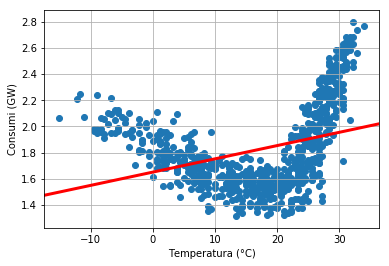

In [29]:
plot_model_on_data(X_train, y_train, lrm)

- Il grafico evidenzia che il consumo non può essere approssimato dalla temperatura in modo soddisfacente con un unico modello lineare (cioè una retta) per tutti i mesi dell'anno

## Regressione Polinomiale

- La regressione _polinomiale_ è una generalizzazione di quella lineare in cui il modello include **termini di grado superiore**
- Ad esempio, mentre un modello di regressione lineare su una singola variabile $x$ (_univariata_) ha forma
$$ \hat{y}=\theta_0+\theta_1\cdot x $$
- in un modello polinomiale di secondo grado viene aggiunto un termine col quadrato della variabile, con un proprio coefficiente:
$$ \hat{y}=\theta_0+\theta_1\cdot x+\theta_2\cdot x^2 $$
- Analogamente, in un modello di terzo grado viene aggiunto un ulteriore termine col cubo della variabile:
$$ \hat{y}=\theta_0+\theta_1\cdot x+\theta_2\cdot x^2+\theta_3\cdot x^3 $$
- La regressione polinomiale corrisponde in pratica a quella lineare con l'aggiunta di variabili derivate da quelle esistenti

## Ottenere Variabili di Grado Superiore

- Per applicare trasformazioni ai dati da fornire ai modelli, scikit-learn fornisce dei _filtri_ con un'interfaccia standard
- Ad esempio, per aggiungere generare le variabili per la regressione polinomiale, usiamo il filtro `PolynomialFeatures`
- In modo simile ai modelli di predizione, un filtro va dapprima creato, impostandone eventuali parametri
- Il parametro più importante di `PolynomialFeatures` è `degree`, che indica il grado massimo delle feature da generare

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)

- Alla prima applicazione di un filtro va usato il metodo `fit_transform`, per far sì che il filtro "apprenda" la struttura dei dati
- Ad esempio, creiamo una matrice con due osservazioni (righe) di una generica variabile (colonna) $X$

In [31]:
sample = np.array([ [ 2],
                    [-3] ])

- Usando `fit_transform`, il filtro
  - apprende che qualsiasi input sarà costituito da una sola colonna (`fit`)
  - applica la trasformazione ai dati passati (`transform`)

In [32]:
poly.fit_transform(sample)

array([[  1.,   2.,   4.,   8.],
       [  1.,  -3.,   9., -27.]])

- Dati i valori di $X$, il filtro ha restituito i valori di $X^0, X^1, X^2, X^3$
- Successive trasformazioni su dati con la stessa struttura (cioè una singola colonna) vanno eseguite col metodo `transform`

- La colonna $X^0$ ha sempre valore 1 ed è inutile nell'addestrare il modello (sarebbe ridondante con l'intercetta)
- Possiamo escluderla impostando `include_bias=False` sul filtro

In [33]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(sample)

array([[  2.,   4.,   8.],
       [ -3.,   9., -27.]])

## Addestrare un Modello Polinomiale

- Per addestrare un modello polinomiale possiamo quindi creare il filtro per l'aggiunta delle feature, ad esempio di secondo grado...

In [34]:
poly = PolynomialFeatures(degree=2, include_bias=False)

- ...e addestrare un modello lineare con i dati trasformati

In [35]:
prm = LinearRegression()
prm.fit(poly.fit_transform(X_train), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

- In seguito, i valori della _x_ dovranno sempre essere trasformati con lo stesso filtro, utilizzando il metodo `transform`
- Ad esempio, per ottenere i consumi predetti a fronte di temperature di -5 °C, 5 °C e 25 °C...

In [36]:
prm.predict(poly.transform([ [-5], [5], [25] ]))

array([2.04296683, 1.59799297, 1.91411279])

## Accuratezza del Modello Polinomiale

- Calcolando le solite misure d'errore su questo nuovo modello...

In [37]:
print_eval(poly.transform(X_val), y_val, prm)

   Mean squared error: 0.031921
       Relative error: 7.60952%
R-squared coefficient: 0.73124


- ...otteniamo risultati molto migliori di quelli che avevamo ottenuto col modello lineare

In [38]:
print_eval(X_val, y_val, lrm)

   Mean squared error: 0.098769
       Relative error: 14.19269%
R-squared coefficient: 0.16842


## Pipeline

- Nelle istruzioni sopra, ad ogni interazione col modello `prm`, abbiamo dovuto esplicitamente trasformare i dati col filtro `poly`
- scikit-learn permette di comporre uno o più filtri con un modello creando una **_pipeline_**
- Una volta costruita, la pipeline offre la **stessa API del modello** di predizione incapsulato, ma **applica automaticamente i filtri** ai dati prima di passarli al modello
  - chiamando `fit`, i filtri sono "tarati" e applicati (`fit_transform`) sui dati di addestramento
  - chiamando `predict` (o `score`), i filtri (già tarati) sono nuovamente applicati ai nuovi dati (`transform`)
- Ad esempio, per incapsulare il modello polinomiale visto sopra in un oggetto unico, usiamo una pipeline con il filtro `PolynomialFeatures` e il modello lineare
  - al costruttore va passata la lista ordinata dei componenti, ciascuno rappresentato da una tupla con nome e componente

In [39]:
from sklearn.pipeline import Pipeline
prm = Pipeline([
    # nome     elemento
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", LinearRegression())
])

- Possiamo ora eseguire le stesse operazioni vista sopra sul modello, ma con la trasformazione dei dati applicata in automatico

In [40]:
prm.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [41]:
prm.predict([ [-5], [5], [25] ])

array([2.04296683, 1.59799297, 1.91411279])

In [42]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.031921
       Relative error: 7.60952%
R-squared coefficient: 0.73124


## Curva del Modello Polinomiale

- Visualizzando il modello polinomiale di secondo grado in un grafico, vediamo che ha la forma di una funzione $a\cdot x^2+b\cdot x+c$, ovvero una parabola

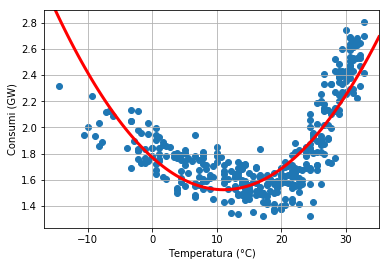

In [43]:
plot_model_on_data(X_val, y_val, prm)

- Come anche confermato dalle misure di errore, questo modello approssima molto meglio il consumo in base alla temperatura rispetto a quello lineare

## Standardizzazione dei Dati

- Data una variabile $X$ con media $\mu$ e deviazione standard $\sigma$, la sua versione "standard" è calcolata come
$$ Z = \frac{X-\mu}{\sigma} $$
- $Z$ mantiene la distribuzione dei dati di $X$, ma con media 0 e deviazione standard 1
- In presenza di più variabili con scale diverse, applicare la standardizzazione a ciascuna di esse è utile per uniformarne i valori
- Questo può migliorare l'accuratezza dei modelli di regressione

- La standardizzazione si esegue col filtro `StandardScaler`
- Eseguendo `fit_transform` (o `fit`) il filtro memorizza medie e deviazioni standard dei dati passati

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform([[0.001, 4000],
                      [0.002, 2500],
                      [0.004, 1000]])

array([[-1.06904497,  1.22474487],
       [-0.26726124,  0.        ],
       [ 1.33630621, -1.22474487]])

- Successivamente `transform` trasformerà ulteriori dati secondo medie e deviazioni memorizzate

In [45]:
scaler.transform([ [0.01, 100] ])

array([[ 6.14700856, -1.95959179]])

- Addestriamo un modello polinomiale di secondo grado come quello sopra, ma applicando la standardizzazione alle variabili $X$ e $X^2$
- Per far ciò, basta aggiungere il filtro alla pipeline

In [46]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),   # <- aggiunto
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

- Valutiamo l'accuratezza del modello

In [47]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.031921
       Relative error: 7.60952%
R-squared coefficient: 0.73124


- In questo caso le metriche di accuratezza non sono cambiate standardizzando i dati
- Ma cosa succede con più variabili con ordini di grandezza molto diversi?

- Addestriamo e valutiamo un nuovo modello polinomiale, questa volta di grado 15, quindi con variabili $X,X^2,\ldots,X^{15}$

In [49]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=15, include_bias=False)),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)
print_eval(X_val, y_val, prm)

   Mean squared error: 0.023056
       Relative error: 6.52098%
R-squared coefficient: 0.80588


- Addestriamo e valutiamo lo stesso modello applicando la standardizzazione

In [50]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=15, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)
print_eval(X_val, y_val, prm)

   Mean squared error: 0.018719
       Relative error: 5.84395%
R-squared coefficient: 0.84239


- Avendo a che fare con molte variabili di ordini di grandezza diversi, la standardizzazione ha migliorato l'accuratezza del modello

## Regolarizzazione e Regressione Ridge

- Abbiamo visto come l'addestramento di un modello si compia minimizzando l'errore sui dati di addestramento, dato da
$$ E = \mathrm{media}\left(\left(\mathbf{X}\mathbf{\theta}-\mathbf{y}\right)^2\right) $$
- Per l'esattezza, la formula su cui si basa `LinearRegression` è
$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 $$
- Dove la _norma euclidea_ (o _norma 2_) $\left\Vert\mathbf{x}\right\Vert_2$ di un vettore $\mathbf{x}$ di $n$ elementi è
$$ \left\Vert\mathbf{x}\right\Vert_2 = \sqrt{\sum_{i=1}^n x_i^2} = \sqrt{x_1^2+\ldots+x_n^2} $$
- Tuttavia, questo non garantisce l'accuratezza del modello in generale
- Soprattutto se il modello ha molti parametri, è possibile che questi vengano "forzati" a funzionare bene sui dati d'addestramento, rendendo però il modello poco accurato in generale

- Addestriamo ad esempio un modello polinomiale di grado 20

In [51]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=20, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=20, include_bias=False, interaction_only=False)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

- Valutiamone le misure di accuratezza sia sul training set che sul validation set

In [52]:
print_eval(X_train, y_train, prm)

   Mean squared error: 0.021281
       Relative error: 6.04719%
R-squared coefficient: 0.79352


In [53]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.045654
       Relative error: 6.90762%
R-squared coefficient: 0.61562


- La differenza tra le misure suggerisce che il modello sia stato addestrato "troppo bene" sul training set ma non sia abbastanza generale (_overfitting_)

- A dimostrazione, si veda il grafico del modello sovrapposto ai dati del training set

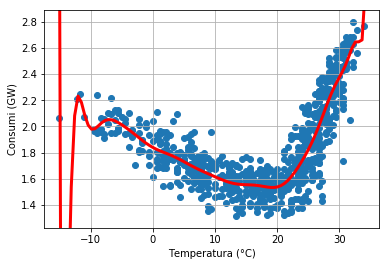

In [54]:
plot_model_on_data(X_train, y_train, prm)

- Soprattutto nella parte a sinistra, si nota che il modello è stato ottimizzato per minimizzare l'errore anche in casi limite del training set

- Vediamo ora il modello sovrapposto al validation set

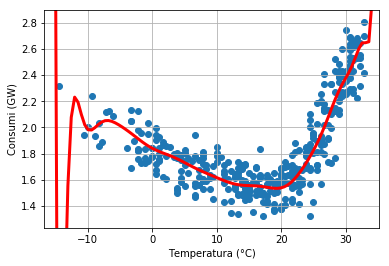

In [55]:
plot_model_on_data(X_val, y_val, prm)

- Si nota che nei casi estremi del validation set, diversi da quelli del training set, l'errore del modello è molto alto

- Vediamo quali sono i coefficienti del modello addestrato
  - `named_steps[X]` permette di accedere al componente col nome `X` della pipeline: lo usiamo per accedere al modello

In [56]:
prm.named_steps["linreg"].coef_

array([-2.78425480e-01,  1.09957013e+00, -2.24250385e+00, -4.79597430e+01,
        1.00699268e+02,  1.17577447e+03, -2.98858246e+03, -1.54754070e+04,
        5.73472338e+04,  6.41450326e+04, -5.13525880e+05,  4.02789609e+05,
        1.66508137e+06, -3.83967162e+06,  1.18036501e+06,  6.10991280e+06,
       -1.04950139e+07,  7.96139091e+06, -3.06223204e+06,  4.86648588e+05])

- I coefficienti per i termini di grado più alto sono molto alti in valore assoluto (${10}^6$)
- Questo causa l'andamento irregolare del modello nei casi estremi e i conseguenti errori
- Come evitare che i coefficienti assumano tali valori?

- La **_regolarizzazione_** modifica la funzione d'errore su cui si basa l'addestramento, aggiungendo una penalità per valori estremi dei parametri del modello
- Nella regolarizzazione _L2_, la più comune, la penalità è proporzionale al quadrato della norma euclidea del vettore $\mathbf{\theta}$ dei parametri
  - in questo modo parametri molto alti in valore assoluto sono molto penalizzati
- La regressione _ridge_ consiste nella regressione lineare con applicata la regolarizzazione L2, utilizzando quindi la seguente funzione d'errore:
$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 + \alpha\left\Vert\mathbf{\theta}\right\Vert_2^2 $$
- $\alpha$ è un parametro impostabile dall'utente che controlla il "peso" della regolarizzazione
  - tali parametri impostabili sono a volte detti _iperparametri_ per distinguerli dai parametri addestrabili del modello

- Per eseguire la regressione ridge usiamo un modello `Ridge`
- Alla creazione del modello è possibile specificare il peso della regolarizzazione con l'opzione `alpha`
- Per il resto l'API della classe `Ridge` è identica a quella di `LinearRegression`, possiamo quindi sostituirla nella pipeline

In [57]:
from sklearn.linear_model import Ridge
rrm = Pipeline([
    ("poly",   PolynomialFeatures(degree=20, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge(alpha=1))
])
rrm.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=20, include_bias=False, interaction_only=False)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

- Verifichiamo i coefficienti del modello addestrato

In [58]:
rrm.named_steps["linreg"].coef_

array([-2.55052849e-01, -2.05065281e-02,  6.41146671e-02,  7.90674102e-02,
        1.34673035e-01,  1.34780143e-01,  1.27965196e-01,  9.56779884e-02,
        5.83152213e-02,  1.64816267e-02, -2.08792706e-02, -5.13070390e-02,
       -7.13742015e-02, -8.00724263e-02, -7.67644651e-02, -6.18051460e-02,
       -3.59146609e-02, -2.09656636e-04,  4.40252048e-02,  9.53946432e-02])

- Vediamo che questa volta sono tutti inferiori a 1 in valore assoluto, per effetto della regolarizzazione

- Con tali, coefficienti, il modello ha un comportamento regolare anche per casi estremi, come si può vedere dal grafico

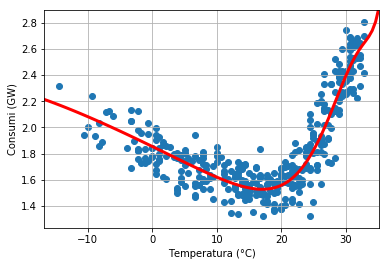

In [59]:
plot_model_on_data(X_val, y_val, rrm)

- Verifichiamo l'accuratezza su training e validation set

In [60]:
print_eval(X_train, y_train, rrm)

   Mean squared error: 0.021587
       Relative error: 6.14427%
R-squared coefficient: 0.79055


In [61]:
print_eval(X_val, y_val, rrm)

   Mean squared error: 0.018798
       Relative error: 5.85777%
R-squared coefficient: 0.84173


- Vediamo che le misure sul training set sono leggermente peggiori di quelle senza regolarizzazione, ma quelle sul validation set sono nettamente migliori

## Esercizi A: Regressione polinomiale al variare del grado

- **1)** Definire una funzione `test_regression` con parametri `degree` e `alpha` che
  - definisca un modello di regressione polinomiale di grado `degree` con standardizzazione dei dati e regolarizzazione L2 con peso `alpha`
  - addestri tale modello sui dati `X_train`, `y_train`
  - restituisca il coefficiente R² del modello calcolato sui dati `X_val`, `y_val`
- **2)** Generare una lista, array o serie di valori restituiti dalla funzione con `alpha=1` e `degree` variabile con valori 5, 10, 15, ..., 50
- **3)** Visualizzare tali risultati in un grafico a linea

In [62]:
def test_regression(X_t, y_t, X_v, y_v, alpha=1, degree=1):
    rrm = Pipeline([
        ("poly",   PolynomialFeatures(degree=degree, include_bias=False)),
        ("scale",  StandardScaler()),
        ("linreg", Ridge(alpha=alpha))
    ])
    
    rrm.fit(X_t, y_t)
    return rrm.score(X_v, y_v)

In [63]:
test_regression(X_t=X_train, y_t=y_train, X_v=X_val, y_v=y_val, alpha=1, degree=15)

0.8409852499422714

In [68]:
a = range(5, 51, 5)
scores = [ test_regression(X_train, y_train, X_val, y_val, 1, d) for d in a ]

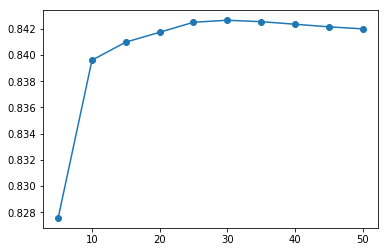

In [69]:
plt.plot(a, scores, "o-")

## Caso di Studio 2: Predizione dei Prezzi delle Case

- Riprendiamo dalla scorsa esercitazione il dataset relativo ai prezzi delle case
- Forniamo tale dataset all'URL _(da caricare)_ già adattato per essere caricato con `read_csv` con le opzioni di default

In [74]:
import os.path
if not os.path.exists("housing.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/fjGjx", "housing.csv")

In [75]:
housing = pd.read_csv("housing.csv")

In [76]:
housing.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

- Eseguiamo la divisione casuale tra training e validation set come sopra
  - la variabile dipendente y è MEDV, il prezzo delle case
  - le variabili indipendenti X sono tutte le altre

In [77]:
X_train, X_val, y_train, y_val = train_test_split(
    housing.drop("MEDV", axis=1),    # X = tutto tranne MEDV
    housing["MEDV"],                 # y = MEDV
    test_size=1/3, random_state=42   # parametri divisione
)

- Addestriamo e valutiamo dapprima un modello lineare semplice

In [78]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [79]:
print_eval(X_val, y_val, model)

   Mean squared error: 20.595
       Relative error: 81.54604%
R-squared coefficient: 0.72621


- Osservando i coefficienti del modello etichettati con i nomi delle colonne, possiamo dedurre il peso che ciascuna variabile ha nella predizione
- Tuttavia, tali pesi dipendono molto dalla scala delle variabili

In [80]:
pd.Series(model.coef_, index=X_train.columns)

CRIM       -0.129470
ZN          0.037960
INDUS       0.060978
CHAS        3.213498
NOX       -16.499614
RM          3.911519
AGE        -0.012602
DIS        -1.427742
RAD         0.239546
TAX        -0.008180
PTRATIO    -0.935991
B           0.011948
LSTAT      -0.546562
dtype: float64

- Applichiamo la standardizzazione ai dati del modello

In [81]:
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
model.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [82]:
print_eval(X_val, y_val, model)

   Mean squared error: 20.595
       Relative error: 81.54604%
R-squared coefficient: 0.72621


/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


- In questo modo anche i coefficienti sono normalizzati, permettendone un confronto alla pari

In [83]:
pd.Series(model.named_steps["linreg"].coef_, X_train.columns)

CRIM      -0.995690
ZN         0.872971
INDUS      0.424808
CHAS       0.857462
NOX       -1.943856
RM         2.820988
AGE       -0.351939
DIS       -3.063072
RAD        2.069621
TAX       -1.356887
PTRATIO   -2.098051
B          1.060004
LSTAT     -3.926623
dtype: float64

## Regressione Lasso

- La regolarizzazione L2 impedisce che i parametri del modello assumano valori troppo alti
- I valori dei parametri sono comunque tutti non nulli, tutte le variabili vengono coinvolte nella predizione
- Vorremmo addestrare un modello meno complesso, dove alcuni parametri hanno valori nulli, **ignorando completamente le variabili meno rilevanti**
  - ad es. variabili con valori dipendenti da altre (_multicollinearità_)
- Questo si può ottenere tramite la regolarizzazione L1, basata sulla norma 1, definita su un vettore $\mathbf{x}$ di $n$ elementi come
$$ \left\Vert\mathbf{x}\right\Vert_1 = \sum_{i=1}^n{\left\vert x_i\right\vert} = \left\vert x_1\right\vert+\ldots+\left\vert x_n\right\vert $$

- La regressione _lasso_ consiste nella regressione lineare con regolarizzazione L1, basata quindi sul minimizzare la funzione d'errore
$$ E = \frac{1}{2m}\left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 + \alpha\left\Vert\mathbf{\theta}\right\Vert_1 $$
- Come per la regressione ridge, il parametro $\alpha$ controlla il peso della regolarizzazione
- La regressione lasso si esegue usando un modello `Lasso`, su cui possiamo impostare come in `Ridge` il parametro `alpha`

In [84]:
from sklearn.linear_model import Lasso
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Lasso(alpha=2))
])
model.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', Lasso(alpha=2, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

- Vediamo i coefficienti del modello risultante

In [85]:
pd.Series(model.named_steps["linreg"].coef_, X_train.columns)

CRIM      -0.000000
ZN         0.000000
INDUS     -0.000000
CHAS       0.000000
NOX       -0.000000
RM         2.137434
AGE       -0.000000
DIS        0.000000
RAD       -0.000000
TAX       -0.000000
PTRATIO   -0.571281
B          0.000000
LSTAT     -3.490547
dtype: float64

- La regolarizzazione L1 ha contribuito ad annullare quanti più coefficienti possibile, creando un modello che considera solo 3 variabili
- Ma qual'è l'accuratezza di tale modello?

In [86]:
print_eval(X_val, y_val, model)

   Mean squared error: 30.795
       Relative error: 19.28526%
R-squared coefficient: 0.59062


/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


- L'accuratezza è nettamente peggiore rispetto ai casi precedenti
- In questo caso la regolarizzazione è stata quindi eccessiva

- Cosa succede diminuendo il parametro `alpha`, ovvero il peso della regolarizzazione?

In [87]:
from sklearn.linear_model import Lasso
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Lasso(alpha=0.1)) # <-- cambiato da 2
])
model.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [88]:
pd.Series(model.named_steps["linreg"].coef_, X_train.columns)

CRIM      -0.677400
ZN         0.434023
INDUS     -0.000000
CHAS       0.873061
NOX       -1.392679
RM         2.903934
AGE       -0.173488
DIS       -2.273983
RAD        0.501967
TAX       -0.000000
PTRATIO   -1.909058
B          0.953566
LSTAT     -3.961146
dtype: float64

- I coefficienti non nulli sono aumentati da 5 a 11

In [89]:
print_eval(X_val, y_val, model)

   Mean squared error: 21.636
       Relative error: 41.77503%
R-squared coefficient: 0.71237


/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


- L'accuratezza è simile a quella ottenuta col modello di regressione ridge
- Questo modello è però molto più semplice, in quanto si basa su 7 variabili invece di 20

## Elastic Net

- La regressione _elastic net_ combina insieme le regolarizzazioni L2 e L1 usate in ridge e lasso
- Si applica in scikit-learn tramite la classe `ElasticNet`, per cui l'errore è calcolato come:
$$ E = \underbrace{\frac{1}{2m} ||X\theta - y||_2 ^ 2}_{\text{errore sui dati}} + \underbrace{\alpha \rho ||\theta||_1}_{\text{L1}} + \underbrace{\frac{\alpha(1-\rho)}{2} ||\theta||_2 ^ 2}_{\text{L2}} $$
- I parametri impostabili sono
  - `alpha` ($\alpha$) che determina il peso generale della regolarizzazione
  - `l1_ratio` ($\rho$, compreso tra 0 e 1) che determina il peso di L1 relativo al totale (con $\rho=1$ si ha la regressione lasso, con $\rho=0$ la ridge)

In [90]:
from sklearn.linear_model import ElasticNet
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet(alpha=0.2, l1_ratio=0.1))
])
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

   Mean squared error: 22.092
       Relative error: 27.75110%
R-squared coefficient: 0.70631


/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transfo

## Regressione Polinomiale Multivariata

- Abbiamo visto sopra che la regressione polinomiale su una sola variabile $X$ (univariata) usa le variabili $X,X^2,X^3,\ldots$
- In presenza di più di una variabile, la regressione polinomiale genera tutti i possibili termini fino al grado impostato, includendo anche **termini basati su più variabili**
- Vediamo un esempio con 2 generiche variabili $A$ e $B$

In [91]:
#                     A   B
sample = np.array([ [ 2, -3],
                    [ 4, -5] ])

- Applicando il filtro `PolynomialFeatures` con grado 2...

In [92]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform(sample)

array([[  2.,  -3.,   4.,  -6.,   9.],
       [  4.,  -5.,  16., -20.,  25.]])

- Le variabili generate (escludendo il grado nullo) sono 5: $A,B,A^2,AB,B^2$
- Oltre ai quadrati delle singole variabili abbiamo quindi anche i prodotti tra di esse

- Aumentando il grado massimo, le variabili generate **aumentano rapidamente**
- Ad esempio, aumentando il grado da 2 a 3...

In [93]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(sample)

array([[   2.,   -3.,    4.,   -6.,    9.,    8.,  -12.,   18.,  -27.],
       [   4.,   -5.,   16.,  -20.,   25.,   64.,  -80.,  100., -125.]])

- ...generiamo 9 variabili: $A,B,A^2,AB,B^2,A^3,A^2B,AB^2,B^3$

- Cosa succede con un numero iniziale di variabili più alto?
- Prendiamo ad esempio la matrice `X_train`, con 13 variabili

In [94]:
X_train.shape

(337, 13)

- Generando le feature polinomiali con grado massimo 2...

In [95]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform(X_train).shape

(337, 104)

- ...otteniamo 104 feature distinte!

- Aumentando ulteriormente il grado, il numero di variabili cresce enormemente
  - con grado 10 si supera il milione di variabili

In [96]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(X_train).shape

(337, 559)

In [97]:
poly = PolynomialFeatures(degree=4, include_bias=False)
poly.fit_transform(X_train).shape

(337, 2379)

In [98]:
poly = PolynomialFeatures(degree=8, include_bias=False)
poly.fit_transform(X_train).shape

(337, 203489)

- All'aumentare delle variabili, aumenta il tempo necessario per l'addestramento del modello
- Proviamo ad esempio ad addestrare un modello polinomiale di grado 2
- Usiamo il comando "magico" `%time` per riportare in output il tempo di esecuzione

In [99]:
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet(alpha=0.5, l1_ratio=0.2))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

CPU times: user 19.7 ms, sys: 0 ns, total: 19.7 ms
Wall time: 18.1 ms
   Mean squared error: 19.854
       Relative error: 19.59672%
R-squared coefficient: 0.73606


- L'addestramento richiede pochi centesimi di secondo

- Verifichiamo ora cosa accade con grado 5

In [100]:
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=5, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet(alpha=0.5, l1_ratio=0.2))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


CPU times: user 3.54 s, sys: 22.4 ms, total: 3.56 s
Wall time: 3.56 s
   Mean squared error: 11.969
       Relative error: 13.09187%
R-squared coefficient: 0.84089


- L'accuratezza del modello è migliorata sensibilmente, ma **il tempo per addestrarlo è aumentato di oltre 100 volte**
  - con dataset più grandi, avremmo tempi di addestramento insostenibili

## Regressione con Funzioni Kernel

- Nella regressione polinomiale si eseguono prodotti tra dati con dimensioni aggiunte e rappresentate esplicitamente
- Le _funzioni kernel_ permettono di calcolare gli stessi prodotti senza calcolare esplicitamente le dimensioni aggiunte
- Questo permette di ottenere modelli non lineari senza l'aggiunta di variabili
- Esistono diverse funzioni kernel utilizzabili con diversi parametri impostabili
- Ad esempio, il kernel polinomiale è definito dalla formula
$$ K(\mathbf{a},\mathbf{b}) = \left(\mathbf{a}\cdot\mathbf{b}+c\right)^d $$
  - $d$ e $c$ sono parametri del kernel, in particolare $d$ è il grado del polinomio

- La classe `KernelRidge` implementa la regressione ridge con l'applicazione di una funzione kernel
- Col parametro `kernel` si indica il tipo di kernel con una stringa, ad es. `"poly"` per un kernel polinomiale
- Ulteriori parametri riguardano il kernel, per quello polinomiale sono `degree` ($d$) e `coef0` ($c$)

In [101]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=5))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

CPU times: user 16.7 ms, sys: 0 ns, total: 16.7 ms
Wall time: 20.8 ms
   Mean squared error: 14.765
       Relative error: 13.59065%
R-squared coefficient: 0.80371


/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transfo

- Abbiamo ottenuto un'accuratezza più elevata rispetto ai modelli lineari, ma in tempi molto più brevi rispetto alla regressione polinomiale

- Possiamo testare anche funzioni kernel diverse, ad esempio RBF (_radial basis function_)
  - RBF ha valori tanto più elevati quanto più i valori X sono vicini a 0 (ovvero la media, usando dati standardizzati)
- La funzione RBF ha la forma di una gaussiana, di cui si può impostare l'ampiezza col parametro `gamma`

In [102]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="rbf", gamma=0.001))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

CPU times: user 20.5 ms, sys: 3.24 ms, total: 23.8 ms
Wall time: 22.2 ms
   Mean squared error: 63.544
       Relative error: 25.64160%
R-squared coefficient: 0.15525


/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transfo

- In questo caso specifico il kernel RBF non funziona bene tanto quanto il polinomiale

## k-Fold Cross Validation

- Il metodo _k-fold_ è un'alternativa al metodo hold-out per valutare l'accuratezza di un modello
  - i dati sono divisi causalmente in k gruppi (_fold_)
  - ciascun gruppo è validato su un modello addestrato su tutti gli altri gruppi
  - i risultati dei singoli test sono aggregati
- Per iniziare, definiamo gli oggetti `X` e `y` con i valori di variabili indipendenti e dipendente dell'intero dataset, invece di usare le partizioni create con `train_test_split`

In [103]:
X = housing.drop(["MEDV"], axis=1)
y = housing["MEDV"]

- La classe `KFold` definisce oggetti che generano un dato numero di fold su un insieme di dati
- Creiamo ad esempio un oggetto che genera 5 fold con dati mescolati casualmente

In [104]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=42)

- La funzione `cross_val_score` esegue una validazione di un modello sui diversi fold generati da un set di dati
- Alla funzione vanno passati
  - la definizione di un modello, che viene addestrato una volta per ciascun fold
  - i dati, divisi come per `fit` in valori delle variabili indipendenti (X) e di quella dipendente (y)
  - l'oggetto che genera i fold dai dati
- Utilizziamo ad esempio un modello polinomiale di grado 2 senza regolarizzazione

In [105]:
from sklearn.model_selection import cross_val_score
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
scores = cross_val_score(model, X, y, cv=kf)

- La funzione restituisce il risultato di `score`, ovvero il coefficiente R², calcolato su ciascun fold

In [106]:
scores

array([0.80558294, 0.78699438, 0.76305893, 0.91222428, 0.83023822])

- Calcoliamo media e deviazione standard di tali punteggi

In [107]:
scores.mean(), scores.std()

(0.8196197495647295, 0.051281426990255896)

- Il punteggio medio dei modelli è 0,82 con una deviazione standard di 0,05
- Tale valutazione è più affidabile di quella col metodo hold-out, ottenuta da un singolo modello
- Ci permette inoltre di valutare la "robustezza" del modello, ovvero quanto l'accuratezza sia stabile addestrandosi su set di dati diversi

- Riproviamo ad esempio la cross-validation con modello polinomiale come sopra, ma con regolarizzazione L2

In [108]:
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])
scores = cross_val_score(model, X, y, cv=kf)
scores

array([0.84717914, 0.83199436, 0.83630888, 0.91408914, 0.8335903 ])

In [109]:
scores.mean(), scores.std()

(0.8526323637761564, 0.03118222818925484)

- I valori di R² individuati, oltre ad essere più alti in media, hanno una variabilità più bassa rispetto a quelli sopra

## Grid Search

- Sui modelli utilizzati finora abbiamo impostato manualmente i valori di diversi iperparametri
  - grado della regressione polinomiale, peso della regolarizzazione, ...
- L'accuratezza del modello può dipendere fortemente da questi valori
- Scelto un generico modello da utilizzare (es. regressione polinomiale o kernel ridge), vorremmo **individuare i valori degli iperparametri che ne massimizzino l'accuratezza**
- scikit-learn fornisce un supporto per eseguire automaticamente la cross validation un modello con diversi valori degli iperparametri tramite la _grid search_

- Consideriamo ad esempio un modello _elastic net_ di cui fissiamo arbitrariamente il parametro `l1_ratio`

In [110]:
model = ElasticNet(l1_ratio=0.2)

- Vorremmo trovare il migliore valore possibile del parametro `alpha` tra un insieme di valori possibili, ovvero:

In [111]:
candidate_alphas = [0.1, 1, 10]

- Creiamo ora la _griglia_ dei parametri, ovvero un dizionario in cui associamo ai nomi dei parametri variabili i valori che possono assumere
- In questo caso abbiamo un unico parametro variabile, `alpha`

In [112]:
grid = {"alpha": candidate_alphas}

- Definiamo ora un modello `GridSearchCV` indicando
  - il modello "base" con i parametri fissati a priori
  - la griglia dei parametri variabili

In [113]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, param_grid=grid)

- Come per i modelli base, usiamo il metodo `fit` per eseguire l'addestramento, passando la matrice X e il vettore y
- Per ogni valore possibile di `alpha`, scikit-learn esegue la cross-validation per calcolare il punteggio R² medio del modello con quel valore di `alpha`
  - di default si esegue cross-validation con 3 fold

In [114]:
gs.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.2,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

- In seguito ai test, il modello viene (di default) riaddestrato su tutti i dati, usando gli iperparametri che han dato il miglior punteggio medio
- Possiamo quindi utilizzarlo come un modello ordinario

In [115]:
# prezzo predetto per la prima riga del validation set
gs.predict(X_val.iloc[[0]])

array([28.35759953])

In [99]:
print_eval(X_val, y_val, gs)

   Mean squared error: 21.905
       Relative error: 22.68926%
R-squared coefficient: 0.7088


- Dall'attributo `best_params_` possiamo vedere quali sono i valori selezionati degli iperparametri per tale modello

In [116]:
gs.best_params_

{'alpha': 0.1}

- L'attributo `cv_results_` fornisce risultati dettagliati su tutti gli iperparametri testati

In [117]:
gs.cv_results_

/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You

{'mean_fit_time': array([0.00238856, 0.00191712, 0.00172154]),
 'std_fit_time': array([4.22631318e-04, 1.38557096e-04, 5.71900967e-05]),
 'mean_score_time': array([0.0009102 , 0.00073878, 0.00072797]),
 'std_score_time': array([2.11914049e-05, 3.03521824e-05, 1.64909535e-05]),
 'param_alpha': masked_array(data=[0.1, 1, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1}, {'alpha': 1}, {'alpha': 10}],
 'split0_test_score': array([0.68144422, 0.68502031, 0.61945439]),
 'split1_test_score': array([0.73833888, 0.67469173, 0.57072577]),
 'split2_test_score': array([0.65965525, 0.61364258, 0.49467571]),
 'mean_test_score': array([0.69311139, 0.65786569, 0.56179024]),
 'std_test_score': array([0.03312793, 0.03148495, 0.0513663 ]),
 'rank_test_score': array([1, 2, 3], dtype=int32),
 'split0_train_score': array([0.74951813, 0.69517926, 0.56987566]),
 'split1_train_score': array([0.69238995, 0.66489684, 0.57200556]),
 'spl

- Incapsuliamo tali risultati in un DataFrame per visualizzarli meglio ed ordinarli per punteggio decrescente

In [118]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.002389      0.000423         0.000910        0.000021         0.1   
1       0.001917      0.000139         0.000739        0.000030           1   
2       0.001722      0.000057         0.000728        0.000016          10   

           params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.1}           0.681444           0.738339           0.659655   
1    {'alpha': 1}           0.685020           0.674692           0.613643   
2   {'alpha': 10}           0.619454           0.570726           0.494676   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.693111        0.033128                1            0.749518   
1         0.657866        0.031485                2            0.695179   
2         0.561790        0.051366                3            0.569876   

   split1_train_score  split2_train_score  mean_train_score  std_train_score  
0            0.692390            0.743261          0.728390         0.025583  
1            0.664897            0.709392          0.689823         0.018556  
2            0.572006            0.611809          0.584563         0.019285

- Cosa succede con due iperparametri variabili?
- Oltre a 3 valori possibili per `alpha`, impostiamo 3 valori possibili anche per `l1_ratio`

In [119]:
model = ElasticNet()
grid = {
    "alpha":    [0.1, 1, 10],
    "l1_ratio": [0.1, 0.2, 0.3]
}
gs = GridSearchCV(model, param_grid=grid)
gs.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 1, 10], 'l1_ratio': [0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [120]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
2       0.001975      0.000138         0.000795    2.848301e-05         0.1   
1       0.003358      0.000071         0.001291    6.331738e-05         0.1   
0       0.003735      0.000177         0.001506    9.861432e-05         0.1   
3       0.001821      0.000024         0.000729    1.449242e-05           1   
4       0.001825      0.000044         0.000722    2.057994e-05           1   
5       0.001812      0.000051         0.000706    3.371748e-07           1   
6       0.001684      0.000031         0.000700    3.059447e-06          10   
7       0.001719      0.000028         0.000871    2.258653e-04          10   
8       0.001583      0.000022         0.000735    4.647647e-05          10   

  param_l1_ratio                           params  split0_test_score  \
2            0.3  {'alpha': 0.1, 'l1_ratio': 0.3}           0.680593   
1            0.2  {'alpha': 0.1, 'l1_ratio': 0.2}           0.681444   
0            0.1  {'alpha': 0.1, 'l1_ratio': 0.1}           0.682165   
3            0.1    {'alpha': 1, 'l1_ratio': 0.1}           0.684541   
4            0.2    {'alpha': 1, 'l1_ratio': 0.2}           0.685020   
5            0.3    {'alpha': 1, 'l1_ratio': 0.3}           0.685464   
6            0.1   {'alpha': 10, 'l1_ratio': 0.1}           0.629260   
7            0.2   {'alpha': 10, 'l1_ratio': 0.2}           0.619454   
8            0.3   {'alpha': 10, 'l1_ratio': 0.3}           0.609944   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
2           0.739205           0.660113         0.693266        0.033474   
1           0.738339           0.659655         0.693111        0.033128   
0           0.737497           0.659175         0.692914        0.032827   
3           0.676556           0.614055         0.658462        0.031500   
4           0.674692           0.613643         0.657866        0.031485   
5           0.673114           0.613395         0.657408        0.031460   
6           0.583246           0.513920         0.575635        0.047427   
7           0.570726           0.494676         0.561790        0.051366   
8           0.565277           0.476111         0.550621        0.055646   

   rank_test_score  split0_train_score  split1_train_score  \
2                1            0.750202            0.692489   
1                2            0.749518            0.692390   
0                3            0.748832            0.692265   
3                4            0.695597            0.666169   
4                5            0.695179            0.664897   
5                6            0.694644            0.663825   
6                7            0.588116            0.585056   
7                8            0.569876            0.572006   
8                9            0.552774            0.562271   

   split2_train_score  mean_train_score  std_train_score  
2            0.743462          0.728718         0.025765  
1            0.743261          0.728390         0.025583  
0            0.743037          0.728045         0.025410  
3            0.709971          0.690579         0.018231  
4            0.709392          0.689823         0.018556  
5            0.708930          0.689133         0.018822  
6            0.627859          0.600344         0.019496  
7            0.611809          0.584563         0.019285  
8            0.598753          0.571266         0.019819

- scikit-learn ha generato e testato **tutte le combinazioni possibili** dei valori degli iperparametri, in tutto $3\times 3=9$ configurazioni

- Possiamo usare `GridSearchCV` anche con una pipeline, testando diversi valori anche per i parametri dei filtri
- Consideriamo ad esempio un modello polinomiale di grado variabile con regolarizzazione L2

In [121]:
model = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  Ridge())
])

- Per riferirsi ai parametri dei singoli componenti usiamo la notazione `nomeComponente__parametro`

In [122]:
grid = {
    "poly__degree": [2, 3],      # <- grado polinomio
    "regr__alpha":  [0.1, 1, 10] # <- regolarizzazione
}
gs = GridSearchCV(model, param_grid=grid)

In [123]:
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_scor

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       0.026021      0.000399         0.005128        0.000128   
2       0.004570      0.000136         0.001619        0.000035   
4       0.026622      0.000336         0.005093        0.000110   
1       0.004555      0.000103         0.001662        0.000061   
0       0.005780      0.001703         0.001920        0.000414   
3       0.026602      0.000216         0.005039        0.000043   

  param_poly__degree param_regr__alpha  \
5                  3                10   
2                  2                10   
4                  3                 1   
1                  2                 1   
0                  2               0.1   
3                  3               0.1   

                                    params  split0_test_score  \
5   {'poly__degree': 3, 'regr__alpha': 10}           0.749572   
2   {'poly__degree': 2, 'regr__alpha': 10}           0.755172   
4    {'poly__degree': 3, 'regr__alpha': 1}           0.718411   
1    {'poly__degree': 2, 'regr__alpha': 1}           0.770550   
0  {'poly__degree': 2, 'regr__alpha': 0.1}           0.741104   
3  {'poly__degree': 3, 'regr__alpha': 0.1}           0.624984   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
5           0.875462           0.809381         0.811288        0.051449   
2           0.848731           0.773258         0.792276        0.040510   
4           0.791608           0.852248         0.787218        0.054766   
1           0.749085           0.821233         0.780260        0.030209   
0           0.584570           0.811640         0.712523        0.094763   
3           0.318003           0.788345         0.577253        0.194705   

   rank_test_score  split0_train_score  split1_train_score  \
5                1            0.946569            0.924609   
2                2            0.897655            0.849699   
4                3            0.970498            0.962014   
1                4            0.941433            0.915434   
0                5            0.958982            0.940569   
3                6            0.982842            0.979719   

   split2_train_score  mean_train_score  std_train_score  
5            0.936838          0.936005         0.008985  
2            0.885639          0.877664         0.020374  
4            0.965689          0.966067         0.003474  
1            0.931627          0.929498         0.010720  
0            0.951958          0.950503         0.007587  
3            0.982125          0.981562         0.001336

## Esercizi B: Grid Search su Kernel Ridge

- **1)** Creare una funzione `grid_test` che, presi in input un modello e una griglia di parametri
  - esegua una grid search con `X_train`, `y_train` come dati di addestramento con modello e parametri forniti
  - stampi (`print(...)`) il dizionario con gli iperparametri selezionati del modello migliore
  - stampi le misure di accuratezza (`print_eval`) sui dati `X_val`, `y_val`
- **2)** Testare con la funzione sopra un modello di regressione elastic net polinomiale con
  - grado 2 o 3
  - standardizzazione dei dati
  - `alpha` pari a 0.1, 1 o 10
  - `l1_ratio` pari a 0.1, 0.25 o 0.5
- **3)** Testare con la funzione sopra un modello kernel ridge con
  - standardizzazione dei dati
  - kernel polinomiale di grado compreso tra 2 e 10
  - `alpha` (regolarizzazione) pari a 0.01, 0.1, 1 o 10